# Project 3: Where's Waldo?

Due Mar. 4th

So far, we've mostly focused on using imagery to do stuff for which it is better suited than a human: calculating camera locations from imagery, finding an optimal projective transform to stitch images together, and (soon) we'll be doing "structure from motion" in which we create 3D models of the world from collections of 2D images.  These are tasks primarily based around measuring things and doing calculations.  On the other side of the coin is object recognition (identifying the semantic content of a scene), and the best contemporary computer vision algorithms do object recognition at roughly the level of a 2 year old human (with some exceptions).  For this (mini-)project, we're going to delve into a topic that sort of straddles the line between these two general realms of computer vision.

As a motivating example, did you ever play the game Where's Waldo.  There are books filled with images like the following:
<img src='waldo_1.jpg'>
The objective, of course, is to find Waldo, the man in the red striped shirt and beanie wearing glasses.  He looks like this:
<img src='waldo_template.jpg'>
These scenes are (obviously) intended to have a bunch of visual clutter to make this task reasonably challenging.

Your task will be to come up with an algorithm that locates the template image (Waldo's face) and the target image (the larger scene).  This is called *template matching*, and it's a primitive form of feature recognition.  

## Implementation
### Template Matching
Template matching works in a way that is very similar to filtering:  slide the template image over every location in the target image, computing some sort of metric at each position.  In practice, one commonly used choice for an error metric is the one that you've already used for matching keypoint descriptors: z-normalized sum square error.  Another choice is [normalized cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Normalization).  Once these metrics have been computed, simply find the argmin (for SSE) or argmax (for NCC), and this will be the location of the best match.  

**Your task is to implement template matching.  Use 'waldo_template.jpg' as the template and 'waldo_1.jpg' as the target image.  Where's Waldo? **

### Not so fast!!!  What about scale!
Oh, no.  As it turns out, the template I've provided is not the same scale as the Waldo in the image.  To deal with this, you'll need to create an image pyramid for the template (See Szeliski 3.5, and [Mubarak Shah's lecture on this topic](https://www.youtube.com/watch?v=KO7jJt0WHag&feature=youtu.be)).  This essentially just means creating a sequence of downsampled images of the template, and trying each one in hopes that one of the resulting down-scaled templates matches the feature in the target image.  **Create a sequence of templates with which to perform feature matching, each one 1/2 the resolution of the previous (so 1/4 the total number of pixels).  To avoid aliasing, before downsampling perform a $\sigma=1$ Gaussian Blur of the image.  Once you've built your image pyramid, find the argmin/max in 3 dimensions (u,v,template scale)**.

## Generalization
**Waldo appears in every Where's Waldo image (obviously).  Try using the same technique on 'waldo_2.jpg'.  Does the algorithm work?**  I confess that I pulled the image of waldo for the template directly from 'waldo_1.jpg', so for the correct scale, there is something close to an exact match (i.e. SSE=0).  However, Waldo, while easily recognizable to the human eye after undergoing the small scale deformations associated with artistic license, is not so easily recognizable via template matching.  We will return to a similar problem when discussing object recognition, and hopefully this example will motivate the need to come up with representations of objects (like Waldo) that are more robust.


In [1]:
# Import needed libraries
import matplotlib.pyplot as plt
import numpy as np
import imageprocessing as imp
## 

# Waldo template image
waldo_template = plt.imread('waldo_template.jpg').mean(axis=2)

# Where's waldo number 1.
waldo_1 = plt.imread('waldo_1.jpg').mean(axis=2)

# Perform gauss blur of waldo_template
waldo_template = imp.gauss_blur(waldo_template)

# Function to perform the gaussian reduction
def reduce(template, a=.4, b=.25, c=.10):
    
    h = template.shape[0]
    w = template.shape[1]
    reduced = np.zeros((h//2, w//2))
    for i in range(2,h-2):
        for j in range(2,w-2):
            pixel_w = a*template[i][j] + b*template[i+1][j] + b*template[i-1][j] + c*template[i-2][j] + c*template[i+2][j]
            pixel_h = a*template[i][j] + b*template[i][j+1] + b*template[i][j-1] + c*template[i][j+2] + c*template[i][j-2]
            reduced[i//2][j//2] = (pixel_w + pixel_h) / 2
    
    # Just cut off the image border, it's easier this way
    new_h = reduced.shape[0]-4
    new_w = reduced.shape[1]-4
    trimmed = np.zeros((new_h, new_w))
    trimmed = reduced[2:reduced.shape[0]-2, 2:reduced.shape[1]-2]
    return trimmed

# Function that creates the image pyramid calling the gaussian reduction
def create_pyramid(template):
    image_pyramid = []
    image_pyramid.append(template)
    while(template.shape[0] > 25):
        template = reduce(template)
        image_pyramid.append(template)
        
        
    return image_pyramid

image_pyramid = create_pyramid(waldo_template)

In [2]:
'''# Show the image pyramid
for image in image_pyramid:
    print(image.shape)
    plt.imshow(image, cmap="gray")
    plt.show()
'''   

'# Show the image pyramid\nfor image in image_pyramid:\n    print(image.shape)\n    plt.imshow(image, cmap="gray")\n    plt.show()\n'

In [3]:
# Find waldo
# Height and width of waldo_1.jpg
map_height = waldo_1.shape[0]
map_width = waldo_1.shape[1]

# Variables to store best_sse, and i,j of best_sse
best_sse = np.inf
best_location = None

for template in image_pyramid:
    temp_h = template.shape[0]
    temp_w = template.shape[1]
    print("Searcing for waldo with template of size :", (temp_h, temp_w))
    for i in range(temp_h, map_height):
        for j in range(temp_w, map_width):
            image_patch = waldo_1[i-temp_h:i, j-temp_w:j]
            sse = imp.sum_squared_error(template, image_patch)
            if(sse < best_sse):
                best_sse = sse
                best_location = [(i-temp_h,j-temp_w), template]

# Finished now print the best location!
print("Found waldo at: ", best_location[0])
        
        


Searcing for waldo with template of size : (124, 100)
Searcing for waldo with template of size : (58, 46)


/Users/addisonwesleyboyer/Desktop/project_3-mini-project/imageprocessing.py:6: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((((D1-np.mean(D1))/np.std(D1)) - ((D2-np.mean(D2))/np.std(D2)))**2)


Searcing for waldo with template of size : (25, 19)
Found waldo at:  (603, 1588)


In [4]:
print(map_height, map_width)

1760 2800


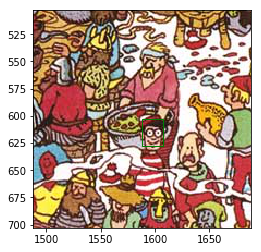

In [23]:
import matplotlib.patches as pat
# Get original color image
waldo_1 = plt.imread('waldo_1.jpg')
fig,ax = plt.subplots(1)
x = best_location[0][1]
y = best_location[0][0]
plt.axis([x-100,x+100,y+100,y-100])
temp_h = len(best_location[1])
temp_w = len(best_location[1][0])
rect = pat.Rectangle([x,y], temp_w, temp_h, color="green", fill=False)
ax.imshow(waldo_1)
ax.add_patch(rect)
plt.show()